In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import re
from pprint import pprint
from matplotlib.path import Path
from matplotlib.patches import BoxStyle



thisyear = 2018
#this_state = 'MO'

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_contrast_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
color_reset_point = 18

debug = 1
g = 0




def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
old_map_buffer_ratio = -1
print('ok')



ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.2 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 146.5 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 15.5 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

# READ FROM FILE

## Get what has been matched so far

In [6]:
# s = time.time()
# print('reading districts that have been matched so far...')
# #assembler_df = pandas.read_csv(output_dir+'raw_district_files/dallas.csv', encoding='utf-8', index_col='GEOID')
# assembler_df = pandas.read_csv(output_dir+'raw_district_files/ak_to_tx.csv', encoding='utf-8', index_col='GEOID')
# assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
# assembler_gdf.crs = bg_gdf.crs


# # cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# # bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

# #print('backing up...')
# # cd_gdf_bk = cd_gdf
# # bg_gdf_bk = bg_gdf
# #assembler_gdf_bk = assembler_gdf

# e = time.time()
# g = g + (e-s)
# print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))

# assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)



### READ AFRESH

In [7]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_27.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


# cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
# bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 217,739 block groups in 2.7 seconds!


## Texas

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [8]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    #working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    #if (debug > 0):    
    #    print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(block_group_info_gdf)))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(block_group_info_gdf)))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')
#assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [9]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk



for this_state in ['TX']:
#     try:
#         print('reading previously-parsed {0:} census tracts from file...'.format(this_state))
#         assembler_from_file_gdf = geopandas.read_file(output_dir+'raw_district_files/{0:}_raw.shp'.format(this_state.lower()))
#         assembler_gdf = pandas.concat((assembler_gdf, assembler_from_file_gdf), axis=0, sort=True)
#     except:
#    print('File not found, reading from nationwide data...')
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)


    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        

    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')

    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))

    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1

    #assembler_i_gdf.to_file(output_dir+'raw_district_files/nj_raw.shp')

    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=True)
    if (debug > 0):
        print("\n")
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(e-s, ))
print('Got {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T
#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


#matched districts for 15,811 block groups in TX in 46 minutes 1 seconds!
#backing up...
#Got 167,172 block groups in 46 minutes 1 seconds!

getting from backup...


Processing Texas...
		processing row 1 of 15,811...
		processing row 101 of 15,811...
		processing row 201 of 15,811...
		processing row 301 of 15,811...
		processing row 401 of 15,811...
		processing row 501 of 15,811...
		processing row 601 of 15,811...
		processing row 701 of 15,811...
		processing row 801 of 15,811...
		processing row 901 of 15,811...
		processing row 1,001 of 15,811...
		processing row 1,101 of 15,811...
		processing row 1,201 of 15,811...
		processing row 1,301 of 15,811...
		processing row 1,401 of 15,811...
		processing row 1,501 of 15,811...
		processing row 1,601 of 15,811...
		processing row 1,701 of 15,811...
		processing row 1,801 of 15,811...
		processing row 1,901 of 15,811...
		processing row 2,001 of 15,811...
		processing row 2,101 of 15,811...
		processing row 2,201 of 15,811...
		processing row 2,301 of 15,811...
		processing row 2,401 of 15,811...
		processing row 2,501 of 15,811...
		processing row 2,601 of 15,811...
		pro

STUSAB
TX    36.0
FL    27.0
NY    27.0
PA    18.0
IL    18.0
OH    16.0
GA    14.0
MI    14.0
NC    13.0
NJ    12.0
VA    11.0
WA    10.0
MA     9.0
TN     9.0
IN     9.0
AZ     9.0
MD     8.0
WI     8.0
MN     8.0
MO     8.0
SC     7.0
AL     7.0
CO     7.0
LA     6.0
KY     6.0
CT     5.0
OK     5.0
OR     5.0
MS     4.0
IA     4.0
KS     4.0
AR     4.0
UT     4.0
NV     4.0
NE     3.0
WV     3.0
NM     3.0
ME     2.0
ID     2.0
NH     2.0
HI     2.0
RI     2.0
WY     1.0
MT     1.0
DE     1.0
ND     1.0
SD     1.0
VT     1.0
AK     1.0
Name: block_based_district, dtype: float64

In [10]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')


print('assigning districts...')

### TEXAS
######## Dallas / Fort Worth
assembler_gdf.loc[['15000US484599505001', '15000US484599505003', '15000US484599505001', '15000US484599503004', '15000US484599504004', '15000US484599504001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US484599506002', '15000US484599503001', '15000US484599503002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US484999501002', '15000US484999503011', '15000US484999503012'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US484999501003', '15000US484999507001', '15000US484999507003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US480850311001', '15000US480850311002', '15000US480850311003', '15000US480850303052'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US480850301003', '15000US480850301001', '15000US480850302021', '15000US480850302035', '15000US480850303053', '15000US480850311006', '15000US480850312011', '15000US480850312012', '15000US480850302022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US480850313171', '15000US480850313157'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US480850313172', '15000US480850313081', '15000US480850313082', '15000US480850313158', '15000US480850313135'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US480850312021'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US481130169035'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130178052', '15000US481130178062', '15000US481130179003', '15000US481130178051', '15000US481130179002', '15000US481130117021', '15000US481130118001', '15000US481130119005', '15000US481130170042', '15000US481130171011', '15000US481130170013'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130122081', '15000US481130122092', '15000US481130012021', '15000US481130122071', '15000US481130123023', '15000US481130125002', '15000US481130125004', '15000US481130125005', '15000US481130171021', '15000US481130117023', '15000US481130171012'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130181302', '15000US481130181042', '15000US481130181261', '15000US481130185013', '15000US481130080001', '15000US481130080003', '15000US481130001003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130128003', '15000US481130185061', '15000US481130130081', '15000US481130130073'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130078091', '15000US481130078122', '15000US481130078152', '15000US481130078153', '15000US481130078192', '15000US481130185032', '15000US481130185062'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US481130178112', '15000US481130178113', '15000US481130181291', '15000US481130181292', '15000US481130181321', '15000US481130181323', '15000US481130183003', '15000US481130185012', '15000US481130184031', '15000US481130184012', '15000US481130080002', '15000US481130080004', '15000US481130080005', '15000US481130080006', '15000US481130079023'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US481130190192', '15000US481130130051', '15000US481130190331', '15000US481130190332', '15000US481130190333', '15000US481130190143', '15000US481130130102', '15000US481130130113'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US484391110083'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391110181', '15000US484391055122', '15000US484391060014'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391110163', '15000US484391112042'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391110161', '15000US484391110162'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US484391115362', '15000US484391115241', '15000US484391228011', '15000US484391130021', '15000US484391130011'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391115361', '15000US484391115211', '15000US484391115212', '15000US484391115223', '15000US484391115224', '15000US484391228023', '15000US484391115242', '15000US484391228013', '15000US484391131021', '15000US484391131141', '15000US484391130024'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391131132', '15000US484391221001', '15000US484391224005', '15000US484391221002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391131131', '15000US484391221003', '15000US484391217022', '15000US484391217021', '15000US484391221004'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391064001', '15000US484391013022', '15000US484391060043'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391222001', '15000US484391217042', '15000US484391217041', '15000US484391217031', '15000US484391222002', '15000US484391217033', '15000US484391060042', '15000US484391111021', '15000US484391013023', '15000US484391014023', '15000US484391064002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391015001', '15000US484391014011', '15000US484391014012', '15000US484391131082', '15000US484391065144', '15000US484391065121', '15000US484391065123', '15000US484391065034', '15000US484391065021', '15000US484391065032'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US484391015004', '15000US484391013014', '15000US484391014021', '15000US484391014031', '15000US484391014032', '15000US484391065091', '15000US484391065142', '15000US484391065031', '15000US484391065141'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484971506012', '15000US484971506021', '15000US484971501023', '15000US484971501024' , '15000US484971502001', '15000US484971502002'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484971501013', '15000US484971501022', '15000US484971506013', '15000US484971506014', '15000US484971501021'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US484391132134'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391134032', '15000US484391134053'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US484391141032', '15000US484391141035', '15000US484391139265', '15000US484391138104', '15000US484391139226', '15000US484391139172', '15000US484391139192', '15000US484391139194', '15000US484391139196', '15000US484391139174'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391132102', '15000US484391139221', '15000US484391139227', '15000US484391139173'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US484391060011', '15000US484391043001', '15000US484391043005', '15000US484391042022', '15000US484391042024', '15000US484391056004'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391012011', '15000US484391043003', '15000US484391044003', '15000US484391048023', '15000US484391044001', '15000US484391044002', '15000US484391048022' , '15000US484391056001', '15000US484391056002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391104022', '15000US484391104023', '15000US484391232001', '15000US484391007001'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391049001', '15000US484391009002', '15000US484391012012', '15000US484391012022', '15000US484391012023', '15000US484391005021', '15000US484391050061', '15000US484391104021', '15000US484391049002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391001022', '15000US484391103025'], 'block_based_district'] = 12
assembler_gdf.loc[['15000US484391002022', '15000US484391005015', '15000US484391017002', '15000US484391103022', '15000US484391103023', '15000US484391231001'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US484391136101', '15000US484391139063', '15000US484391139072', '15000US484391139061', '15000US484391139103', '15000US481210216251', '15000US481210216252', '15000US481210216231', '15000US481130200002', '15000US481130141231', '15000US481130141341'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US484391139123', '15000US484391139104', '15000US481210203054', '15000US481210216241', '15000US481210217282', '15000US481210216201', '15000US481210217372', '15000US481130141342', '15000US481210217371', '15000US481210217381'], 'block_based_district'] = 26
assembler_gdf.loc[['15000US481130004063', '15000US481130100002'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481130096031', '15000US481130096092', '15000US481130095001', '15000US481130095002'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US481130096041', '15000US481130096043', '15000US481130135001', '15000US481130073023', '15000US481130073021', '15000US481130096091', '15000US481130096094'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US484391065173', '15000US484391065092', '15000US481130145012', '15000US481130146011', '15000US481130096051', '15000US481130096111', '15000US481130097021', '15000US481130094012', '15000US481130097013'], 'block_based_district'] = 24
assembler_gdf.loc[['15000US484391065181', '15000US481130201001', '15000US481130144073', '15000US481130144081', '15000US481130146012', '15000US481130147012', '15000US481130147013', '15000US481130145022', '15000US481130146021', '15000US481130145021', '15000US481130099002', '15000US481130094011', '15000US481130097011'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481439507001', '15000US481439502012', '15000US481439502022'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US482899503001'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US481130001002', '15000US481130012041', '15000US481130017011', '15000US481130017042', '15000US481130005001', '15000US481130005003', '15000US481130005004'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130013011', '15000US481130024002', '15000US481130015022', '15000US481130015043', '15000US481130004041', '15000US481130004044'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US481130004052', '15000US481130008004', '15000US481130008005', '15000US481130015044', '15000US481130016002', '15000US481130018002', '15000US481130004013'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130004051', '15000US481130005002', '15000US481130008003'], 'block_based_district'] = 32
assembler_gdf.loc[['15000US481130164081', '15000US481130165212', '15000US481130162021', '15000US481130162023', '15000US481139801001', '15000US481130004065', '15000US481130108032', '15000US481130108036'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130107032', '15000US481130161001', '15000US481130162011', '15000US481130163011', '15000US481130004061', '15000US481130108034'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481130060021', '15000US481130069001', '15000US481130054002', '15000US481130054004', '15000US481130062002', '15000US481130020001', '15000US481130020002', '15000US481130101011'], 'block_based_district'] = 30
assembler_gdf.loc[['15000US481130205001', '15000US481130101021', '15000US481130043001', '15000US481130060011', '15000US481130056003', '15000US481130048004', '15000US481130048001', '15000US481130020003'], 'block_based_district'] = 33
assembler_gdf.loc[['15000US481130042012', '15000US481130042013', '15000US481130042021', '15000US481130056004', '15000US481130062003'], 'block_based_district'] = 33



###### Houston
assembler_gdf.loc[['15000US482015217004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482014132012', '15000US482014133004', '15000US482014133002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482014123002', '15000US482014133003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015210001', '15000US482015223012', '15000US482015223021', '15000US482015223022'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482014501001', '15000US482014502001', '15000US482014502003', '15000US482014503002', '15000US482014504001', '15000US482014505001', '15000US482014303001', '15000US482015225001', '15000US482015225003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015401001', '15000US482015401003', '15000US482015517022', '15000US482015342031'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482015518001', '15000US482015518002', '15000US482015518003', '15000US482015408002', '15000US482015519001', '15000US482015520012'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015547002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482015548021', '15000US482012413003', '15000US482015542001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482015547001', '15000US482012414002', '15000US482015548011'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482014122001', '15000US482014122003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482015543012', '15000US482015543021', '15000US482015543022'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482012410004', '15000US482012506001', '15000US482012409012', '15000US482015512002', '15000US482015340031', '15000US482015218001', '15000US482015220002', '15000US482015214003', '15000US482015220003', '15000US482015218002', '15000US482014106001', '15000US482015107001', '15000US482015107002', '15000US482015115006', '15000US482015112002', '15000US482015112003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482012501002', '15000US482012408021', '15000US482012415001', '15000US482015507001', '15000US482015340022', '15000US482015324001', '15000US482015340021', '15000US482015512001', '15000US482015218001', '15000US482015313002', '15000US482015220002', '15000US482015215004', '15000US482015221003', '15000US482014101001', '15000US482015111002'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012504021'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482012503012'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012519013', '15000US482012519014', '15000US482012520001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US482012519022'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US482014544001', '15000US482014328024', '15000US482014226002', '15000US482014325003', '15000US482014326002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482014221001', '15000US482014225003', '15000US482014226003', '15000US482014329012', '15000US482014226004', '15000US482014228002', '15000US482014325001', '15000US482014325002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US482015422001', '15000US482015430031', '15000US482015522003', '15000US482015521032', '15000US482015521021'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US482015430021', '15000US482015521023', '15000US482015524003'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482015549021', '15000US482015553022', '15000US482015548022', '15000US482015555021', '15000US482015555011', '15000US482015555022'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482015555012', '15000US482015553031', '15000US482015553021', '15000US482015549022'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482899502003', '15000US482899503004'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US482899502002'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US482013312001', '15000US482013320002', '15000US482013311004'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US482013126001', '15000US482013311001', '15000US482013324001', '15000US482013131001', '15000US482013139001'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US481576718002', '15000US481576708003', '15000US481576709022', '15000US481576701013', '15000US481576707001', '15000US481576708001', '15000US481576711002', '15000US481576711003', '15000US481576713001'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US481576729001', '15000US481576730022', '15000US481576724002', '15000US481576724004', '15000US481576714001', '15000US481576711001', '15000US481576714002'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US482013326002', '15000US482013336001', '15000US482013331002'], 'block_based_district'] = 9
assembler_gdf.loc[['15000US482013336002', '15000US482013332011'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US480396618002', '15000US480396619001', '15000US480396615021', '15000US480396615022', '15000US480396616013', '15000US480396616022', '15000US480396616012'], 'block_based_district'] = 14
assembler_gdf.loc[['15000US480396606021', '15000US480396616014'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US480717104013'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US482012321002', '15000US482012320002', '15000US482012415003', '15000US482012401001', '15000US482015333002', '15000US482015307002', '15000US482015304002', '15000US482012205003', '15000US482015114001', '15000US482015114003', '15000US482015115003', '15000US482015307001', '15000US482015307003'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012321001', '15000US482012322004', '15000US482012227001', '15000US482012318002', '15000US482012401002', '15000US482012214001', '15000US482015115002', '15000US482012107003'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012108001', '15000US482012108002', '15000US482012201001', '15000US482012208001', '15000US482012207003', '15000US482012123005', '15000US482012123004'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012104004', '15000US482015116004', '15000US482012104001', '15000US482012105002', '15000US482012107001', '15000US482012305003', '15000US482012207004', '15000US482012107002', '15000US482012123002', '15000US482012104002'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012325001', '15000US482012124002', '15000US482012114002', '15000US482012334002', '15000US482012125001', '15000US482012334001'], 'block_based_district'] = 18
assembler_gdf.loc[['15000US482012115002', '15000US482012116001', '15000US482012116002', '15000US482013104001', '15000US482012125003', '15000US482012326002', '15000US482012337011', '15000US482013103003'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482013501002', '15000US482013340031', '15000US482013340033'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US482013339011', '15000US482013211001', '15000US482013340032', '15000US482013401001'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482013402011', '15000US482013411002', '15000US482013412011', '15000US482013405002', '15000US482013405005', '15000US482013407002', '15000US482013407003'], 'block_based_district'] = 22
assembler_gdf.loc[['15000US482013212002', '15000US482013240002', '15000US482013406002'], 'block_based_district'] = 36
assembler_gdf.loc[['15000US482012522002', '15000US482012523021', '15000US482013211003', '15000US482012523013', '15000US482012331021', '15000US482013227001', '15000US482013226001', '15000US482012524002', '15000US482013213002', '15000US482013235003', '15000US482013241003', '15000US482013424001'], 'block_based_district'] = 29
assembler_gdf.loc[['15000US482012525001', '15000US482013425001', '15000US482012524003', '15000US482013422001', '15000US482013213003'], 'block_based_district'] = 36






###  REST OF STATE
assembler_gdf.loc[['15000US482899503002'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US482870002003', '15000US484530018582', '15000US484530018592', '15000US480219502005', '15000US484530017561'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US482870001001', '15000US482870001002', '15000US482870001003', '15000US484530018591', '15000US480219501001', '15000US480219502001', '15000US484530018541', '15000US484530018552', '15000US484530018621', '15000US484530018411', '15000US484530018391'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US484530018413', '15000US484530018622', '15000US484530018352', '15000US484530018492', '15000US484530018261'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US484530018403', '15000US484530017221', '15000US484530017541', '15000US484530018262', '15000US484530018353', '15000US484530018501', '15000US484530025003'], 'block_based_district'] = 17
assembler_gdf.loc[['15000US484530017652', '15000US484530019122', '15000US484530019131', '15000US484530017162', '15000US484530017053', '15000US484530017651'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US484530017801', '15000US484530017051', '15000US484530017191'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US484530017512', '15000US484530001013', '15000US484530021052', '15000US484530003042', '15000US484530002043'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US484530017511', '15000US484530016041', '15000US484530019101', '15000US484530021041', '15000US484530021121', '15000US484530021122', '15000US484530021133', '15000US484530016042'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US480219506001', '15000US480219505021', '15000US480219504002', '15000US480219507004'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US480219506002', '15000US480219503005', '15000US480219507002'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US484530022101', '15000US484530018342', '15000US484530018123', '15000US484530018222', '15000US484530018052'], 'block_based_district'] = 10
assembler_gdf.loc[['15000US484530024331', '15000US484530022121', '15000US484530022023', '15000US484530022071', '15000US484530018051', '15000US484530018341'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US480291310001'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US484299505002', '15000US484299502003', '15000US484299502001', '15000US484299502002', '15000US484299503001', '15000US484299503003'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US484299505003'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US481439502021', '15000US481439502023', '15000US481439503003', '15000US481439503005'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US481439505003', '15000US481439505004', '15000US481439505005', '15000US481439506003', '15000US481439506001'], 'block_based_district'] = 11
assembler_gdf.loc[['15000US481439505002', '15000US481439506002'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US481539505001', '15000US481539506001'], 'block_based_district'] = 13
assembler_gdf.loc[['15000US481539506002', '15000US481539506005'], 'block_based_district'] = 19
assembler_gdf.loc[['15000US482150241122', '15000US482150241061', '15000US484930005001', '15000US484930006003'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US482150242012', '15000US482150241121', '15000US482150241142', '15000US482150201023', '15000US482150203012', '15000US482150241063', '15000US482150241092'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US482150218062', '15000US482150229001', '15000US482150229002'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US482150228003', '15000US482150213023', '15000US482150213032'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US482150218052', '15000US482150218061', '15000US482150218063', '15000US482150219031', '15000US482150219034', '15000US482150221031', '15000US482150221032', '15000US482150221033', '15000US482150222012', '15000US482150222041'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US481872106041', '15000US481872106043', '15000US481872107112', '15000US481872107121', '15000US481872107063'], 'block_based_district'] = 15
assembler_gdf.loc[['15000US481872106042', '15000US481872107111', '15000US481872107061'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US481410039031', '15000US481410039033', '15000US481410040031'], 'block_based_district'] = 16
assembler_gdf.loc[['15000US481410039021', '15000US481410040032', '15000US481410040043'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US480291811004', '15000US480291813021', '15000US480291810031', '15000US480291810033', '15000US480291815041', '15000US480291909023', '15000US480291911023', '15000US480291207011', '15000US480291207013', '15000US480291913041', '15000US480291913042', '15000US480291904001', '15000US480291904003'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US480291811003', '15000US480291814031', '15000US480291818132', '15000US480291912021', '15000US480291912024', '15000US480291912012', '15000US480291207021', '15000US480291904002'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US480291719171', '15000US480291719172', '15000US480291719183', '15000US480291719184', '15000US480291719231', '15000US480291719234', '15000US480291719242', '15000US480291720031', '15000US480291510003'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US480291610002', '15000US480291611002', '15000US480291611004', '15000US480291618021', '15000US480291618022', '15000US480291820021', '15000US480291819012', '15000US480291915032'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US480299800031', '15000US480291611003', '15000US480291611005', '15000US480291612001', '15000US480291918072', '15000US480291915041'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US480291918121'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US480291914054', '15000US480291813012', '15000US480291914121', '15000US480291918081', '15000US480291918082'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US480291902005', '15000US480291516004', '15000US480291707001', '15000US480291601004', '15000US480291601002', '15000US480291503002', '15000US480291503004', '15000US480291507002', '15000US480291602002'], 'block_based_district'] = 20
assembler_gdf.loc[['15000US480291905013', '15000US480291705001', '15000US480291709003', '15000US480291708001', '15000US480291601001', '15000US480291507005', '15000US480291602001'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US482090109051'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US480913108021', '15000US480291218124', '15000US480913105032', '15000US480913103001', '15000US480913103003', '15000US480913102003', '15000US480913103004', '15000US480913105012'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US480913109021', '15000US480913108012', '15000US480913108022', '15000US480913105011', '15000US480913101004', '15000US480291205013', '15000US480291308001'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US480291920002', '15000US480291110002', '15000US480291920001', '15000US480291211121', '15000US480291212041', '15000US482090101001', '15000US482090101002', '15000US482090102001', '15000US482090107012', '15000US482090109022', '15000US484530024282', '15000US484530014032', '15000US484530023142', '15000US484530023131', '15000US484530020031', '15000US484530023072', '15000US484530023074'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US480291902003', '15000US480291920004', '15000US480291920005', '15000US480291110001', '15000US480291920003', '15000US480291211112', '15000US482090105001', '15000US482090102002', '15000US484530024341', '15000US482090109081', '15000US482090109023', '15000US484530024021', '15000US484530013083'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US480291312001', '15000US480291312002', '15000US480291517004', '15000US480291519001', '15000US480291519002'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US480291517001'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US480291215011', '15000US480291213002', '15000US480291214031', '15000US480291218031', '15000US480291214033', '15000US480291215042'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US480291315043', '15000US480291315051', '15000US480291315062', '15000US480291214021', '15000US480291310002', '15000US480291315033', '15000US480291315061', '15000US480291214022', '15000US480291214032', '15000US480291214041'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US480291213001', '15000US480291218032'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US480291214042'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US482090107011', '15000US482090107022', '15000US482090106004', '15000US482090109021', '15000US484530017743', '15000US484530017691', '15000US484530017692', '15000US484530019161', '15000US484530019162', '15000US484530017291', '15000US484530017292', '15000US484530011001', '15000US484530006032', '15000US484530006042', '15000US484530006035', '15000US484530007001', '15000US484530016034', '15000US484530016053'], 'block_based_district'] = 21
assembler_gdf.loc[['15000US482090108041', '15000US482090109013', '15000US484530017293', '15000US484530017751', '15000US484530017752', '15000US484530019174', '15000US484530017841', '15000US484530017681', '15000US484530017373', '15000US484530017385', '15000US484530017761', '15000US484530006031', '15000US484530016052'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US482839503001'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US482839503002'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US480291522011', '15000US480291522012', '15000US480291522013'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US480291418001', '15000US480291418002'], 'block_based_district'] = 28
assembler_gdf.loc[['15000US480270231052', '15000US480270231085', '15000US480270231073'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US480270232022', '15000US480270231085', '15000US480270231071'], 'block_based_district'] = 31
assembler_gdf.loc[['15000US480270231064', '15000US480270231084', '15000US480279800021', '15000US480279800011'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US480270231074'], 'block_based_district'] = 31
assembler_gdf.loc[['15000US484530022012', '15000US484530022081'], 'block_based_district'] = 25
assembler_gdf.loc[['15000US484530009024', '15000US484530022011', '15000US484530022111'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US481770002002', '15000US481770006001'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US484090107001', '15000US484090109003', '15000US484090112003', '15000US484090110002'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US484090109002', '15000US484090111001', '15000US484090111003', '15000US484090110001', '15000US484090109001'], 'block_based_district'] = 34
assembler_gdf.loc[['15000US480559601022', '15000US480559602003'], 'block_based_district'] = 27
assembler_gdf.loc[['15000US480559601011', '15000US480559605002', '15000US480559603001', '15000US480559603003'], 'block_based_district'] = 35
assembler_gdf.loc[['15000US480291821062', '15000US480291821031', '15000US480291821061'], 'block_based_district'] = 23
assembler_gdf.loc[['15000US480291419003'], 'block_based_district'] = 28

# print('backing up...')
# assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)

print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False))


#assembler_gdf.groupby('STUSAB').size()

Assigning districts based on examination to block groups that overlap multiple districts...
assigning districts...
Grand total time: 96 minutes 26 seconds!


# WRITE OUTPUT

In [11]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_36.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 194,077 block groups in 0 minutes 7 seconds!
GRAND TOTAL TIME: 96  minutes 34 seconds!


# TEST that output wrote correctly

In [12]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_36.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 150.4 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 7.9 seconds


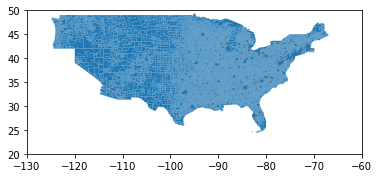

In [13]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()

# TEXAS

## Get water areas for whole state

### From save

In [14]:
# s = time.time()
# water_gdf = geopandas.read_file(shapefiledir+'texas/water_texas.shp')
# place_gdf = geopandas.read_file(shapefiledir+'texas/place_texas.shp')
# roads_gdf = geopandas.read_file(shapefiledir+'texas/roads_texas.shp')
# e = time.time()
# print('Read Texas water/place/road shapefiles in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


### From scratch

In [15]:
# s = time.time()

# this_state = 'TX'
# this_state_number = 48
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading area water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of linear water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# old_map_buffer_ratio = -1

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     print('Read {0:,.0f} roads in  {1:,.0f} minutes {2:,.0f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# s = time.time()
# water_gdf.to_file(shapefiledir+'texas/water_texas.shp')
# place_gdf.to_file(shapefiledir+'texas/place_texas.shp')
# roads_gdf.to_file(shapefiledir+'texas/roads_texas.shp')
# e = time.time()

# print('Wrote outfiles in {0:,.0f} seconds!'.format(e-s))
print('ok')

ok


## DALLAS, HOUSTON

In [16]:
# s = time.time()
# this_state = 'TX'
# nDistricts = 36
# color_reset_point = 17

# #### DALLAS
# dallas_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Palo Pinto County')].geometry.tolist()).bounds[2] - 0.025 # East border of Palo Pinto County
# dallas_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Denton County')].geometry.tolist()).bounds[3] + 0.025   # North border of Denton County
# dallas_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Morris County')].geometry.tolist()).bounds[0] + 0.025   # West border of Morris County
# dallas_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Cherokee County')].geometry.tolist()).bounds[1] - 0.025   # South border of Cherokee County
# xlim = [dallas_west_limit, dallas_east_limit]
# ylim = [dallas_south_limit, dallas_north_limit]

# print('Making Dallas box...')
# dallas_geo = makebox(xlim, ylim)
# if ('in_dallas' not in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.assign(in_dallas = False)
# assembler_gdf.loc[:, 'in_dallas'] = False
# assembler_gdf.loc[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf.geometry.apply(lambda x: x.intersects(dallas_geo))
#       ), 'in_dallas'] = True


# # #### HOUSTON
# houston_west_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Brazos County')].geometry.tolist()).bounds[0] - 0.05 # West: western point of Brazos County
# houston_east_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX')].geometry.tolist()).bounds[2] + 0.25 # East: eastern point of Texas
# houston_south_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Brazoria County')].geometry.tolist()).bounds[1] - 0.05 # South: south point of Brazoria County
# houston_north_limit = unary_union(assembler_gdf[(assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['COUNTY_NAME'] == 'Newton County')].geometry.tolist()).bounds[3] + 0.05 # North: north point of Newton County

# xlim = [houston_west_limit, houston_east_limit]
# ylim = [houston_south_limit, houston_north_limit]

# print('Making Houston box...')
# houston_geo = makebox(xlim, ylim)

# if ('in_houston' not in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.assign(in_houston = False)
# assembler_gdf.loc[:, 'in_houston'] = False
# assembler_gdf.loc[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['in_dallas'] == False) 
#     & (assembler_gdf.geometry.apply(lambda x: x.intersects(houston_geo))), 'in_houston'] = True

# if ('in_neither' not in assembler_gdf.columns):
#     assembler_gdf = assembler_gdf.assign(in_neither = False)
# assembler_gdf.loc[:, 'in_neither'] = False
# assembler_gdf.loc[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['in_dallas'] == False) 
#     & (assembler_gdf['in_houston'] == False), 'in_neither'] = True



# print('Any overlap? Found {0:,.0f} block groups that overlap...'.format(len(assembler_gdf[(assembler_gdf['in_dallas'] == True) & (assembler_gdf['in_houston'] == True)])))
# print('\n')
# print('Found {0:,.0f} block groups in the Dallas area; {1:,.0f} in the Houston area; {2:,.0f} in neither!'.format(len(assembler_gdf[assembler_gdf['in_dallas'] == True]), len(assembler_gdf[assembler_gdf['in_houston'] == True]), len(assembler_gdf[assembler_gdf['in_neither'] == True])))

# print('plotting...')
# dallas_geo_gdf = geopandas.GeoDataFrame(data=[[dallas_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
# houston_geo_gdf = geopandas.GeoDataFrame(data=[[houston_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')

# fig, ax = plt.subplots(1,1, figsize=(12,12))


# # #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax)

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_dallas'] == True)].plot(ax=ax, edgecolor='yellow')
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_houston'] == True)].plot(ax=ax, edgecolor='pink')
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['in_neither'] == True)].plot(ax=ax, edgecolor='black')

# for i in range(1, nDistricts+1):
#     cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].plot(ax=ax, color=district_color_cycle[np.mod(i-1, color_reset_point)-1], alpha=0.5)
#     annotator = i
#     centerpoint = cd_gdf[
#         (cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)
#     ].geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).values[0]
#     plt.annotate(annotator, centerpoint, 
#                  ha='center', va='center', fontsize=8,
#                  color='black', backgroundcolor='white')

# dallas_geo_gdf.plot(ax=ax, color='none', edgecolor='yellow')
# houston_geo_gdf.plot(ax=ax, color='none', edgecolor='pink')

# # # plt.xlim(dallas_west_limit - 0.1, dallas_east_limit + 0.1)
# # # plt.ylim(dallas_south_limit - 0.1, dallas_north_limit + 0.1)
# # # plt.xlim(houston_west_limit - 0.1, houston_east_limit + 0.1)
# # # plt.ylim(houston_south_limit - 0.1, houston_north_limit + 0.1)
# plt.show()
# e = time.time()
# g = g + (e-s)
# # #print('Plotted Dallas and Houston areas in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# print('Defined Dallas and Houston areas in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# print('Done in  {0:,.0f} minutes {0:.1f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



## Divide water/roads/places into Houston, Dallas, other

In [17]:
# s = time.time()
# print('splitting water areas...')
# water_dallas_gdf = water_gdf[water_gdf.geometry.within(dallas_geo)]
# water_houston_gdf = water_gdf[water_gdf.geometry.within(houston_geo)] 
# water_other_gdf = water_gdf[~(water_gdf.geometry.within(dallas_geo)) & ~(water_gdf.geometry.within(houston_geo))] 

# print('splitting places...')
# place_dallas_gdf = place_gdf[place_gdf.geometry.within(dallas_geo)] # 382 rows
# place_houston_gdf = place_gdf[place_gdf.geometry.within(houston_geo)] # 259 rows
# place_other_gdf = place_gdf[~(place_gdf.geometry.within(dallas_geo)) & ~(place_gdf.geometry.within(houston_geo))] # 1105 rows

# print('splitting roads...')
# roads_dallas_gdf = roads_gdf[roads_gdf.geometry.within(dallas_geo)]
# roads_houston_gdf = roads_gdf[roads_gdf.geometry.within(houston_geo)]
# roads_other_gdf = roads_gdf[~(roads_gdf.geometry.within(dallas_geo)) & ~(roads_gdf.geometry.within(houston_geo))] 

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} seconds!'.format(e-s))

In [18]:
# assembler_gdf_bk = assembler_gdf
# print('d')

## DALLAS AREA

In [19]:
# #assembler_gdf = assembler_gdf_bk

# assembler_gdf.loc[['15000US484599505001', '15000US484599505003', '15000US484599505001', '15000US484599503004', '15000US484599504004', '15000US484599504001'], 'block_based_district'] = 1
# assembler_gdf.loc[['15000US484599506002', '15000US484599503001', '15000US484599503002'], 'block_based_district'] = 4
# assembler_gdf.loc[['15000US484999501002', '15000US484999503011', '15000US484999503012'], 'block_based_district'] = 1
# assembler_gdf.loc[['15000US484999501003', '15000US484999507001', '15000US484999507003'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US480850311001', '15000US480850311002', '15000US480850311003', '15000US480850303052'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US480850301003', '15000US480850301001', '15000US480850302021', '15000US480850302035', '15000US480850303053', '15000US480850311006', '15000US480850312011', '15000US480850312012', '15000US480850302022'], 'block_based_district'] = 4
# assembler_gdf.loc[['15000US480850313171', '15000US480850313157'], 'block_based_district'] = 3
# assembler_gdf.loc[['15000US480850313172', '15000US480850313081', '15000US480850313082', '15000US480850313158', '15000US480850313135'], 'block_based_district'] = 32
# assembler_gdf.loc[['15000US480850312021'], 'block_based_district'] = 4
# assembler_gdf.loc[['15000US481130169035'], 'block_based_district'] = 30
# assembler_gdf.loc[['15000US481130178052', '15000US481130178062', '15000US481130179003', '15000US481130178051', '15000US481130179002', '15000US481130117021', '15000US481130118001', '15000US481130119005', '15000US481130170042', '15000US481130171011', '15000US481130170013'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US481130122081', '15000US481130122092', '15000US481130012021', '15000US481130122071', '15000US481130123023', '15000US481130125002', '15000US481130125004', '15000US481130125005', '15000US481130171021', '15000US481130117023', '15000US481130171012'], 'block_based_district'] = 30
# assembler_gdf.loc[['15000US481130181302', '15000US481130181042', '15000US481130181261', '15000US481130185013', '15000US481130080001', '15000US481130080003', '15000US481130001003'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US481130128003', '15000US481130185061', '15000US481130130081', '15000US481130130073'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US481130078091', '15000US481130078122', '15000US481130078152', '15000US481130078153', '15000US481130078192', '15000US481130185032', '15000US481130185062'], 'block_based_district'] = 5
# assembler_gdf.loc[['15000US481130178112', '15000US481130178113', '15000US481130181291', '15000US481130181292', '15000US481130181321', '15000US481130181323', '15000US481130183003', '15000US481130185012', '15000US481130184031', '15000US481130184012', '15000US481130080002', '15000US481130080004', '15000US481130080005', '15000US481130080006', '15000US481130079023'], 'block_based_district'] = 32
# assembler_gdf.loc[['15000US481130190192', '15000US481130130051', '15000US481130190331', '15000US481130190332', '15000US481130190333', '15000US481130190143', '15000US481130130102', '15000US481130130113'], 'block_based_district'] = 32
# assembler_gdf.loc[['15000US484391110083'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US484391110181', '15000US484391055122', '15000US484391060014'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484391110163', '15000US484391112042'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US484391110161', '15000US484391110162'], 'block_based_district'] = 25
# assembler_gdf.loc[['15000US484391115362', '15000US484391115241', '15000US484391228011', '15000US484391130021', '15000US484391130011'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US484391115361', '15000US484391115211', '15000US484391115212', '15000US484391115223', '15000US484391115224', '15000US484391228023', '15000US484391115242', '15000US484391228013', '15000US484391131021', '15000US484391131141', '15000US484391130024'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484391131132', '15000US484391221001', '15000US484391224005', '15000US484391221002'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US484391131131', '15000US484391221003', '15000US484391217022', '15000US484391217021', '15000US484391221004'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484391064001', '15000US484391013022', '15000US484391060043'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US484391222001', '15000US484391217042', '15000US484391217041', '15000US484391217031', '15000US484391222002', '15000US484391217033', '15000US484391060042', '15000US484391111021', '15000US484391013023', '15000US484391014023', '15000US484391064002'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484391015001', '15000US484391014011', '15000US484391014012', '15000US484391131082', '15000US484391065144', '15000US484391065121', '15000US484391065123', '15000US484391065034', '15000US484391065021', '15000US484391065032'], 'block_based_district'] = 6
# assembler_gdf.loc[['15000US484391015004', '15000US484391013014', '15000US484391014021', '15000US484391014031', '15000US484391014032', '15000US484391065091', '15000US484391065142', '15000US484391065031', '15000US484391065141'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484971506012', '15000US484971506021', '15000US484971501023', '15000US484971501024' , '15000US484971502001', '15000US484971502002'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484971501013', '15000US484971501022', '15000US484971506013', '15000US484971506014', '15000US484971501021'], 'block_based_district'] = 13
# assembler_gdf.loc[['15000US484391132134'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484391134032', '15000US484391134053'], 'block_based_district'] = 24
# assembler_gdf.loc[['15000US484391141032', '15000US484391141035', '15000US484391139265', '15000US484391138104', '15000US484391139226', '15000US484391139172', '15000US484391139192', '15000US484391139194', '15000US484391139196', '15000US484391139174'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484391132102', '15000US484391139221', '15000US484391139227', '15000US484391139173'], 'block_based_district'] = 26
# assembler_gdf.loc[['15000US484391060011', '15000US484391043001', '15000US484391043005', '15000US484391042022', '15000US484391042024', '15000US484391056004'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484391012011', '15000US484391043003', '15000US484391044003', '15000US484391048023', '15000US484391044001', '15000US484391044002', '15000US484391048022' , '15000US484391056001', '15000US484391056002'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484391104022', '15000US484391104023', '15000US484391232001', '15000US484391007001'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484391049001', '15000US484391009002', '15000US484391012012', '15000US484391012022', '15000US484391012023', '15000US484391005021', '15000US484391050061', '15000US484391104021', '15000US484391049002'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484391001022', '15000US484391103025'], 'block_based_district'] = 12
# assembler_gdf.loc[['15000US484391002022', '15000US484391005015', '15000US484391017002', '15000US484391103022', '15000US484391103023', '15000US484391231001'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US484391136101', '15000US484391139063', '15000US484391139072', '15000US484391139061', '15000US484391139103', '15000US481210216251', '15000US481210216252', '15000US481210216231', '15000US481130200002', '15000US481130141231', '15000US481130141341'], 'block_based_district'] = 24
# assembler_gdf.loc[['15000US484391139123', '15000US484391139104', '15000US481210203054', '15000US481210216241', '15000US481210217282', '15000US481210216201', '15000US481210217372', '15000US481130141342', '15000US481210217371', '15000US481210217381'], 'block_based_district'] = 26
# assembler_gdf.loc[['15000US481130004063', '15000US481130100002'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US481130096031', '15000US481130096092', '15000US481130095001', '15000US481130095002'], 'block_based_district'] = 24
# assembler_gdf.loc[['15000US481130096041', '15000US481130096043', '15000US481130135001', '15000US481130073023', '15000US481130073021', '15000US481130096091', '15000US481130096094'], 'block_based_district'] = 32
# assembler_gdf.loc[['15000US484391065173', '15000US484391065092', '15000US481130145012', '15000US481130146011', '15000US481130096051', '15000US481130096111', '15000US481130097021', '15000US481130094012', '15000US481130097013'], 'block_based_district'] = 24
# assembler_gdf.loc[['15000US484391065181', '15000US481130201001', '15000US481130144073', '15000US481130144081', '15000US481130146012', '15000US481130147012', '15000US481130147013', '15000US481130145022', '15000US481130146021', '15000US481130145021', '15000US481130099002', '15000US481130094011', '15000US481130097011'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US481439507001', '15000US481439502012', '15000US481439502022'], 'block_based_district'] = 25
# assembler_gdf.loc[['15000US482899503001'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US481130001002', '15000US481130012041', '15000US481130017011', '15000US481130017042', '15000US481130005001', '15000US481130005003', '15000US481130005004'], 'block_based_district'] = 30
# assembler_gdf.loc[['15000US481130013011', '15000US481130024002', '15000US481130015022', '15000US481130015043', '15000US481130004041', '15000US481130004044'], 'block_based_district'] = 32
# assembler_gdf.loc[['15000US481130004052', '15000US481130008004', '15000US481130008005', '15000US481130015044', '15000US481130016002', '15000US481130018002', '15000US481130004013'], 'block_based_district'] = 30
# assembler_gdf.loc[['15000US481130004051', '15000US481130005002', '15000US481130008003'], 'block_based_district'] = 32
# assembler_gdf.loc[['15000US481130164081', '15000US481130165212', '15000US481130162021', '15000US481130162023', '15000US481139801001', '15000US481130004065', '15000US481130108032', '15000US481130108036'], 'block_based_district'] = 30
# assembler_gdf.loc[['15000US481130107032', '15000US481130161001', '15000US481130162011', '15000US481130163011', '15000US481130004061', '15000US481130108034'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US481130060021', '15000US481130069001', '15000US481130054002', '15000US481130054004', '15000US481130062002', '15000US481130020001', '15000US481130020002', '15000US481130101011'], 'block_based_district'] = 30
# assembler_gdf.loc[['15000US481130205001', '15000US481130101021', '15000US481130043001', '15000US481130060011', '15000US481130056003', '15000US481130048004', '15000US481130048001', '15000US481130020003'], 'block_based_district'] = 33
# assembler_gdf.loc[['15000US481130042012', '15000US481130042013', '15000US481130042021', '15000US481130056004', '15000US481130062003'], 'block_based_district'] = 33


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'TX')
#     & (assembler_gdf['in_dallas'] == True)
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


### Find overlapping districts in the Dallas area

In [20]:
# s = time.time()
# #assembler_gdf = assembler_gdf_bk

# this_state = 'TX'
# test_this_bitmask = 'x000000000000000000000000000001001000'
# dallas_districts = []

# for i in range(0, nDistricts+1):
#     if (test_this_bitmask[i] == '1'):
#         dallas_districts.append(i)
#         print(i)

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # 30 vs 33 all
# manual_xlim = (-97.05,-96.8)
# manual_ylim = (32.65,32.87)

# manual_xlim = (-97.05,-96.9)
# manual_ylim = (32.65,32.76)

# legend_location = 'lower left'

# map_buffer_ratio = .1

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     #for i in range(1, len(test_this_bitmask_philly)):
#     for i in dallas_districts:
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:.0f}'.format(i))
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))


# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#             (assembler_gdf['STUSAB'] == 'TX')
#             & (assembler_gdf['in_dallas'] == True)
#             & (assembler_gdf['block_based_district'] == -1)
#             & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=5, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == 'TX')
#                 & (assembler_gdf['in_dallas'] == True)
#                 & (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
# #        print(bounding_box)
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == -1) 
#         & (assembler_gdf['in_dallas'] == True)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_dallas_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_dallas_gdf[~roads_dallas_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_dallas_gdf[roads_dallas_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_dallas_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_dallas_gdf[
#         ((place_dallas_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_dallas_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_dallas_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_dallas_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_dallas_gdf[
#         ((place_dallas_gdf['INTPTLON'] >= xlimits[0]) & (place_dallas_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_dallas_gdf['INTPTLAT'] >= ylimits[0]) & (place_dallas_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



#### Examine a single district in more detail

In [21]:

# #explore_more = ['15000US481130069001']
# s = time.time()

# label_small_roads = True
# label_small_road_types = ['St','Ave']
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 0

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US170978660001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j,color_reset_point)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_dallas_gdf[water_dallas_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_dallas_gdf[roads_dallas_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_dallas_gdf[roads_dallas_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S']))].iterrows():
#     #& (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) ):#| (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_dallas_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_dallas_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_dallas_gdf[
#         ((place_dallas_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_dallas_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_dallas_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_dallas_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



### Do block-based district boundaries approximately follow real boundaries? (Dallas area)

In [22]:
# s = time.time()
# this_state = 'TX'
# nDistricts = 36

# thedistricts = [30,33]

# # 30 vs 33 all
# manual_xlim = (-97.05,-96.8)
# manual_ylim = (32.65,32.87)

# # manual_xlim = (-96.89,-96.82)
# # manual_ylim = (32.75,32.81)

# # # 24 vs 33 all
# # manual_xlim = (-97.21,-96.83)
# # manual_ylim = (32.77,32.93)

# # manual_xlim = (-97.08,-97.04)
# # manual_ylim = (32.79,32.82)

# # # 24 vs 32 all
# # manual_xlim = (-96.87,-96.79)
# # manual_ylim = (32.84,32.94)

# # 24 vs 26 all
# # manual_xlim = (-97.25,-96.8)
# # manual_ylim = (32.76,33.11)

# # 12 vs 33 all
# # manual_xlim = (-97.45,-97.2)
# # manual_ylim = (32.56,32.85)

# # 12 vs 26 all
# # manual_xlim = (-97.43,-97.2)
# # manual_ylim = (32.82,33)

# # 12 vs 13 all
# # manual_xlim = (-97.8,-97.37)
# # manual_ylim = (32.96,33.38)

# # 6 vs 25 ALL
# # manual_xlim = (-97.35,-97)
# # manual_ylim = (32.57,32.84)


# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

# #    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='yellow', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# # print('labeling block groups...')
# # ####  add labels for block groups with overlap
# # b = []
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     #& (assembler_gdf['block_based_district'] == 7) 
# #     #& (assembler_gdf.index == '15000US170318392001')
# #     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# # ].iterrows():
# #     b.append(ix)
# #     annotator = ix[-6:]
# #     ax1.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
# #                )

# print('plotting water...')    
# water_dallas_gdf[
#     (water_dallas_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_dallas_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_dallas_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_dallas_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# # b = sorted(b)
# # for i in range(0,len(b)):
# #     print(b[i])

# plt.show()


## All of Dallas area

In [23]:
# s = time.time()
# color_reset_point = 17
# #assembler_gdf = assembler_gdf_bk
# show_places = True
# map_buffer_ratio = 0.2

# #assembler_gdf.loc[assembler_gdf['block_based_district'] < 0, 'block_based_district'] = -1

# # xlimits = [dallas_west_limit, dallas_east_limit]
# # ylimits = [dallas_south_limit, dallas_north_limit]

# xlimits = [-97.5,-96.4]
# ylimits = [32.4, 33.2]


# # xspan = xlimits[1] - xlimits[0]
# # yspan = ylimits[1] - ylimits[0]

# # xbuffer = xspan * map_buffer_ratio
# # ybuffer = yspan * map_buffer_ratio


# plotbox = makebox(xlimits,ylimits)


# this_state = 'TX'
# nDistricts = 36


# #thedistricts = [5,6,12,30,32,33]
# thedistricts = [3, 4, 5, 6, 12, 24, 25, 26, 30, 32, 33]
# # print('Finding districts present in data...')
# # thedistricts = []
# # for k in range(1,nDistricts+1):
# #     for x in assembler_gdf[(assembler_gdf.geometry.apply(lambda x: x.within(plotbox))) & (assembler_gdf['STUSAB'] == 'TX') & (assembler_gdf['in_dallas'] == True)]['congressional_districts_bitmask'].drop_duplicates().tolist():
# #         if (x[k] == '1'):
# #             if (k not in thedistricts):
# #                 thedistricts.append(k)
# # print(thedistricts)

# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, ax = plt.subplots(1,1,figsize=(16,16))

# print('plotting block-group-based districts...')

# #legend_list = []
# for i in thedistricts:
#     print('Plotting interior of District {0:,.0f}...'.format(i))
#     if (i <= 18):
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#     else:
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#     #legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))

# #ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)

# print('labeling districts...')
# for ix, thisrow in cd_gdf[
#     (cd_gdf['STUSAB'] == this_state) 
#     & (cd_gdf['CD116FP'].isin(thedistricts))
#     & ((cd_gdf['INTPTLON'] >= xlimits[0]) & (cd_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cd_gdf['INTPTLAT'] >= ylimits[0]) & (cd_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     annotator = thisrow['CD116FP']
#     showpoint = (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT']))
#     if (thisrow['CD116FP'] == 26):
#         showpoint = (showpoint[0], showpoint[1] - 0.05)
#     elif (thisrow['CD116FP'] == 32):
#         showpoint = (showpoint[0] + 0.04, showpoint[1])
#     elif (thisrow['CD116FP'] == 33):
#         showpoint = (showpoint[0] + 0.15, showpoint[1] + 0.02)
#     plt.annotate(annotator, showpoint, showpoint, 
#                  fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')

# ax.set_xlim(xlimits)
# ax.set_ylim(ylimits)

# ax.annotate(4, (-96.44,32.9), (-96.44,32.9), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(5, (-96.5,32.72), (-96.5,32.72), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(6, (-97.15,32.65), (-97.15,32.65), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(12, (-97.45,32.72), (-97.45,32.72), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(25, (-97.3, 32.48), (-97.3, 32.48), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')

    
# for i in thedistricts:
#     print('Plotting boundary of District {0:.0f}...'.format(i))
#     this_district_boundary_geo = unary_union(assembler_gdf[
#         (assembler_gdf['STUSAB'] == 'TX') 
#         & (assembler_gdf['block_based_district'] == i)
#     ].geometry.tolist())
    
#     this_district_boundary_gdf = geopandas.GeoDataFrame(data=[[this_district_boundary_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
#     this_district_boundary_gdf.plot(ax=ax, color='none', edgecolor='white', lw=3)

    
# # print('plotting water...')    
# # water_dallas_gdf[
# #     (water_dallas_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_dallas_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #     & (water_dallas_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_dallas_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# # ].plot(ax=ax, color='blue')

# if (show_places):
#     print('plotting places...')
#     biggest_area = 0
#     biggest_dallas_section = np.nan
#     for x in place_dallas_gdf[place_dallas_gdf['NAME'] == 'Dallas'].geometry.values[0]:
#         if (x.area > biggest_area):
#             biggest_dallas_section = x
#             biggest_area = x.area
#     dallas_outer_big_gdf = geopandas.GeoDataFrame(data=[[biggest_dallas_section.boundary[0]]], columns=['geometry'], crs=assembler_gdf, geometry='geometry')
#     #dallas_outer_big_gdf.plot(ax=ax, color='cyan', lw=3)
#     ax.annotate('DALLAS', 
#                 (dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.y)), 
#                 (dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.y))
#                 , fontsize=24, color='red', backgroundcolor='white', va='center', ha='center')
    
#     biggest_area = 0
#     biggest_fort_worth_section = np.nan
#     for x in place_dallas_gdf[place_dallas_gdf['NAME'] == 'Fort Worth'].geometry.values[0]:
#         if (x.area > biggest_area):
#             biggest_fort_worth_section = x
#             biggest_area = x.area
#     fort_worth_outer_big_gdf = geopandas.GeoDataFrame(data=[[biggest_fort_worth_section.boundary[0]]], columns=['geometry'], crs=assembler_gdf, geometry='geometry')
#     #fort_worth_outer_big_gdf.plot(ax=ax, color='cyan', lw=3)
#     ax.annotate('FORT\nWORTH', 
#                 (fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.y)), 
#                 (fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.y))
#                 , fontsize=24, color='red', backgroundcolor='white', va='center', ha='center')

#     print('labeling places...')
#     for ix, thisrow in place_dallas_gdf[
#         (place_dallas_gdf.geometry.within(plotbox))
#         & (place_dallas_gdf['NAME'].isin(['Irving','Mesquite']))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         plt.annotate(annotator, centerpoint, centerpoint, 
#                      fontsize=18, color='red', backgroundcolor='white', va='center', ha='center')

#     # print('plotting places...')
#     # place_dallas_gdf[
#     #     (place_dallas_gdf.geometry.within(plotbox))
#     #     & (place_dallas_gdf['NAME'].isin(['Irving','Mesquite']))
#     # ].plot(ax=ax, color='none', edgecolor='red')

# plt.xticks([])
# plt.yticks([])
# plt.title('Congressional districts in the Dallas / Fort Worth metro area', fontsize=32)
# plt.show()
# fig.savefig(script_dir+'dfw.jpg', format='jpg')

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


## HOUSTON AREA

In [24]:
# #assembler_gdf = assembler_gdf_bk

# assembler_gdf.loc[['15000US482015217004'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482014132012', '15000US482014133004', '15000US482014133002'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482014123002', '15000US482014133003'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US482015210001', '15000US482015223012', '15000US482015223021', '15000US482015223022'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482014501001', '15000US482014502001', '15000US482014502003', '15000US482014503002', '15000US482014504001', '15000US482014505001', '15000US482014303001', '15000US482015225001', '15000US482015225003'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US482015401001', '15000US482015401003', '15000US482015517022', '15000US482015342031'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482015518001', '15000US482015518002', '15000US482015518003', '15000US482015408002', '15000US482015519001', '15000US482015520012'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US482015547002'], 'block_based_district'] = 8
# assembler_gdf.loc[['15000US482015548021', '15000US482012413003', '15000US482015542001'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482015547001', '15000US482012414002', '15000US482015548011'], 'block_based_district'] = 8
# assembler_gdf.loc[['15000US482014122001', '15000US482014122003'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482015543012', '15000US482015543021', '15000US482015543022'], 'block_based_district'] = 10
# assembler_gdf.loc[['15000US482012410004', '15000US482012506001', '15000US482012409012', '15000US482015512002', '15000US482015340031', '15000US482015218001', '15000US482015220002', '15000US482015214003', '15000US482015220003', '15000US482015218002', '15000US482014106001', '15000US482015107001', '15000US482015107002', '15000US482015115006', '15000US482015112002', '15000US482015112003'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482012501002', '15000US482012408021', '15000US482012415001', '15000US482015507001', '15000US482015340022', '15000US482015324001', '15000US482015340021', '15000US482015512001', '15000US482015218001', '15000US482015313002', '15000US482015220002', '15000US482015215004', '15000US482015221003', '15000US482014101001', '15000US482015111002'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US482012504021'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482012503012'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US482012519013', '15000US482012519014', '15000US482012520001'], 'block_based_district'] = 2
# assembler_gdf.loc[['15000US482012519022'], 'block_based_district'] = 36
# assembler_gdf.loc[['15000US482014544001', '15000US482014328024', '15000US482014226002', '15000US482014325003', '15000US482014326002'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US482014221001', '15000US482014225003', '15000US482014226003', '15000US482014329012', '15000US482014226004', '15000US482014228002', '15000US482014325001', '15000US482014325002'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US482015422001', '15000US482015430031', '15000US482015522003', '15000US482015521032', '15000US482015521021'], 'block_based_district'] = 7
# assembler_gdf.loc[['15000US482015430021', '15000US482015521023', '15000US482015524003'], 'block_based_district'] = 10
# assembler_gdf.loc[['15000US482015549021', '15000US482015553022', '15000US482015548022', '15000US482015555021', '15000US482015555011', '15000US482015555022'], 'block_based_district'] = 8
# assembler_gdf.loc[['15000US482015555012', '15000US482015553031', '15000US482015553021', '15000US482015549022'], 'block_based_district'] = 10
# assembler_gdf.loc[['15000US482899502003', '15000US482899503004'], 'block_based_district'] = 8
# assembler_gdf.loc[['15000US482899502002'], 'block_based_district'] = 17
# assembler_gdf.loc[['15000US482013312001', '15000US482013320002', '15000US482013311004'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US482013126001', '15000US482013311001', '15000US482013324001', '15000US482013131001', '15000US482013139001'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US481576718002', '15000US481576708003', '15000US481576709022', '15000US481576701013', '15000US481576707001', '15000US481576708001', '15000US481576711002', '15000US481576711003', '15000US481576713001'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US481576729001', '15000US481576730022', '15000US481576724002', '15000US481576724004', '15000US481576714001', '15000US481576711001', '15000US481576714002'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US482013326002', '15000US482013336001', '15000US482013331002'], 'block_based_district'] = 9
# assembler_gdf.loc[['15000US482013336002', '15000US482013332011'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US480396618002', '15000US480396619001', '15000US480396615021', '15000US480396615022', '15000US480396616013', '15000US480396616022', '15000US480396616012'], 'block_based_district'] = 14
# assembler_gdf.loc[['15000US480396606021', '15000US480396616014'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US480717104013'], 'block_based_district'] = 36
# assembler_gdf.loc[['15000US482012321002', '15000US482012320002', '15000US482012415003', '15000US482012401001', '15000US482015333002', '15000US482015307002', '15000US482015304002', '15000US482012205003', '15000US482015114001', '15000US482015114003', '15000US482015115003', '15000US482015307001', '15000US482015307003'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US482012321001', '15000US482012322004', '15000US482012227001', '15000US482012318002', '15000US482012401002', '15000US482012214001', '15000US482015115002', '15000US482012107003'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US482012108001', '15000US482012108002', '15000US482012201001', '15000US482012208001', '15000US482012207003', '15000US482012123005', '15000US482012123004'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US482012104004', '15000US482015116004', '15000US482012104001', '15000US482012105002', '15000US482012107001', '15000US482012305003', '15000US482012207004', '15000US482012107002', '15000US482012123002', '15000US482012104002'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US482012325001', '15000US482012124002', '15000US482012114002', '15000US482012334002', '15000US482012125001', '15000US482012334001'], 'block_based_district'] = 18
# assembler_gdf.loc[['15000US482012115002', '15000US482012116001', '15000US482012116002', '15000US482013104001', '15000US482012125003', '15000US482012326002', '15000US482012337011', '15000US482013103003'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US482013501002', '15000US482013340031', '15000US482013340033'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US482013339011', '15000US482013211001', '15000US482013340032', '15000US482013401001'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US482013402011', '15000US482013411002', '15000US482013412011', '15000US482013405002', '15000US482013405005', '15000US482013407002', '15000US482013407003'], 'block_based_district'] = 22
# assembler_gdf.loc[['15000US482013212002', '15000US482013240002', '15000US482013406002'], 'block_based_district'] = 36


# assembler_gdf.loc[['15000US482012522002', '15000US482012523021', '15000US482013211003', '15000US482012523013', '15000US482012331021', '15000US482013227001', '15000US482013226001', '15000US482012524002', '15000US482013213002', '15000US482013235003', '15000US482013241003', '15000US482013424001'], 'block_based_district'] = 29
# assembler_gdf.loc[['15000US482012525001', '15000US482013425001', '15000US482012524003', '15000US482013422001', '15000US482013213003'], 'block_based_district'] = 36

# # houston_districts = assembler_gdf[
# #     (assembler_gdf['STUSAB'] == 'TX')
# #     & (assembler_gdf['in_houston'] == True)
# #     & (assembler_gdf['block_based_district'] != -1)
# # ]['block_based_district'].apply(lambda x: int(x)).drop_duplicates().sort_values().tolist()#.groupby('block_based_district').size().sort_index()
# # #print(houston_districts)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'TX')
#     & (assembler_gdf['in_houston'] == True)
#     #& (assembler_gdf['congressional_districts_bitmask'] == 'x010000010000000000000000000000000000')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


In [25]:
# s = time.time()
# color_reset_point = 18

# #assembler_gdf = assembler_gdf_bk

# this_state = 'TX'
# test_this_bitmask = 'x000000000000000000000000000010000001'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # 29 vs 36
# manual_xlim = (-95.23,-95.08)
# manual_ylim = (29.6,29.9)


# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in houston_districts:
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:.0f}'.format(i))
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#             (assembler_gdf['STUSAB'] == 'TX')
#             & (assembler_gdf['in_houston'] == True)
#             & (assembler_gdf['block_based_district'] == -1)
#             & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=5, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == 'TX')
#                 & (assembler_gdf['in_houston'] == True)
#                 & (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
# #        print(bounding_box)
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
     


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == -1) 
#         & (assembler_gdf['in_houston'] == True)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_houston_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_houston_gdf[~roads_houston_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_houston_gdf[roads_houston_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_houston_gdf[roads_houston_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_houston_gdf[roads_houston_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_houston_gdf[roads_houston_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_houston_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_houston_gdf[
#         ((place_houston_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_houston_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_houston_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_houston_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_houston_gdf[
#         ((place_houston_gdf['INTPTLON'] >= xlimits[0]) & (place_houston_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_houston_gdf['INTPTLAT'] >= ylimits[0]) & (place_houston_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




In [26]:

# #explore_more = ['15000US482012207004', '15000US482012107002']
# s = time.time()

# label_small_roads = True
# label_small_road_types = []
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# oldi = -1

# i = 0

# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# #this_block_group_id = '15000US170978660001'

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j,color_reset_point)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='purple', lw=8, zorder=100)
# map_area_gdf.plot(ax=ax, color='none', edgecolor='black', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_houston_gdf[water_houston_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_houston_gdf[roads_houston_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_houston_gdf[roads_houston_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S']))].iterrows():
#     #& (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_houston_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_houston_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_houston_gdf[
#         ((place_houston_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_houston_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_houston_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_houston_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)


In [27]:
# s = time.time()
# this_state = 'TX'
# nDistricts = 36

# thedistricts = [-1,29,36]

# show_real_district_boundaries = True

# # 29 vs 36
# manual_xlim = (-95.23,-95.08)
# manual_ylim = (29.6,29.9)

# # # 22 vs 36
# # manual_xlim = (-95.22,-95.09)
# # manual_ylim = (29.5,29.67)
# # # 22 vs 29
# # manual_xlim = (-95.29,-95.17)
# # manual_ylim = (29.55,29.63)
# # 14 vs 22
# # manual_xlim = (-95.63,-95.14)
# # manual_ylim = (29.25,29.58)
# # # 9 vs 29 all
# # manual_xlim = (-95.315,-95.26)
# # manual_ylim = (29.645,29.682)
# # 9 vs 22 all
# # manual_xlim = (-95.81,-95.39)
# # manual_ylim = (29.48,29.74)
# # 9 vs 18 all
# # manual_xlim = (-95.41,-95.32)
# # manual_ylim = (29.65,29.73)
# # 8 vs 10 all
# # manual_xlim = (-95.73,-95.49)
# # manual_ylim = (29.98,30.18)
# # 7 vs 10 all
# # manual_xlim = (-95.78,-95.58)
# # manual_ylim = (29.82,29.97)
# ## 2 vs 36 all
# # manual_xlim = (-95.65,-95.35)
# # manual_ylim = (29.97,30.13)
# # # 2 vs 18 all
# # manual_xlim = (-95.6,-95.22)
# # manual_ylim = (29.7,30.08)
# # #2 vs 7 all
# # manual_xlim = (-95.68,-95.39)
# # manual_ylim = (29.65,29.95)

# legend_location = 'lower right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))
    
#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

#     if (show_real_district_boundaries):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)
    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     #& (assembler_gdf.index == '15000US482015546001')
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# print('plotting water...')    
# water_houston_gdf[
#     (water_houston_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_houston_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_houston_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_houston_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax2, color='blue')

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()


## All of Houston area

In [28]:
# s = time.time()
# color_reset_point = 18
# #assembler_gdf = assembler_gdf_bk
# show_places = True
# map_buffer_ratio = 0.2

# #assembler_gdf.loc[assembler_gdf['block_based_district'] < 0, 'block_based_district'] = -1

# # xlimits = [houston_west_limit, houston_east_limit]
# # ylimits = [houston_south_limit, houston_north_limit]

# xlimits = [-95.8,-95]
# ylimits = [29.4,30.15]

# plotbox = makebox(xlimits,ylimits)


# this_state = 'TX'
# nDistricts = 36


# thedistricts = [2, 7, 8, 9, 10, 14, 18, 22, 29, 36]

# # print('Finding districts present in data...')
# # thedistricts = []
# # for k in range(1,nDistricts+1):
# #     for x in assembler_gdf[
# #                             (assembler_gdf.geometry.apply(lambda x: x.within(plotbox))) 
# #                             & (assembler_gdf['STUSAB'] == 'TX') 
# #                             & (assembler_gdf['in_houston'] == True)
# #                          ]['congressional_districts_bitmask'].drop_duplicates().tolist():
# #         if (x[k] == '1'):
# #             if (k not in thedistricts):
# #                 thedistricts.append(k)
# # print(thedistricts)

# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, ax = plt.subplots(1,1,figsize=(16,16))

# print('plotting block-group-based districts...')

# #legend_list = []
# for i in thedistricts:
#     print('Plotting interior of District {0:,.0f}...'.format(i))
#     if (i <= 18):
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[i-1], edgecolor='black', lw=0.25)
#     else:
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#     #legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))

# #ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor='purple', lw=3)

# print('labeling districts...')
# for ix, thisrow in cd_gdf[
#     (cd_gdf['STUSAB'] == this_state) 
#     & (cd_gdf['CD116FP'].isin(thedistricts))
#     & ((cd_gdf['INTPTLON'] >= xlimits[0]) & (cd_gdf['INTPTLON'] <= xlimits[1]))
#     & ((cd_gdf['INTPTLAT'] >= ylimits[0]) & (cd_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     annotator = thisrow['CD116FP']
#     showpoint = (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT']))
#     if (thisrow['CD116FP'] == 2):
#         showpoint = (showpoint[0] + 0.05, showpoint[1])
#     elif (thisrow['CD116FP'] == 7):
#         showpoint = (showpoint[0] + 0.1, showpoint[1] - 0.025)
#     elif (thisrow['CD116FP'] == 9):
#         showpoint = (showpoint[0], showpoint[1] - 0.01)
#     elif (thisrow['CD116FP'] == 18):
#         showpoint = (showpoint[0] + 0.2, showpoint[1] + 0.12)
#     elif (thisrow['CD116FP'] == 22):
#         showpoint = (showpoint[0], showpoint[1] + 0.12)
#     elif (thisrow['CD116FP'] == 29):
#         showpoint = (showpoint[0] + 0.2, showpoint[1] - 0.25)
#     plt.annotate(annotator, showpoint, showpoint, 
#                  fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')

# ax.set_xlim(xlimits)
# ax.set_ylim(ylimits)

# ax.annotate(8, (-95.3,30.1), (-95.3,30.1), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(10, (-95.77,29.96), (-95.77,29.96), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(14, (-95.1,29.44), (-95.1,29.44), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')
# ax.annotate(36, (-95.05,29.75), (-95.05,29.75), fontsize=24, color='black', backgroundcolor='white', ha='center', va='center')

    
# for i in thedistricts:
#     print('Plotting boundary of District {0:.0f}...'.format(i))
#     this_district_boundary_geo = unary_union(assembler_gdf[
#         (assembler_gdf['STUSAB'] == 'TX') 
#         & (assembler_gdf['block_based_district'] == i)
#     ].geometry.tolist())
    
#     this_district_boundary_gdf = geopandas.GeoDataFrame(data=[[this_district_boundary_geo]], columns=['geometry'], crs=assembler_gdf.crs, geometry='geometry')
#     this_district_boundary_gdf.plot(ax=ax, color='none', edgecolor='white', lw=3)

    
# print('plotting water...')    
# water_houston_gdf[
#     (water_houston_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_houston_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
#     & (water_houston_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_houston_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# ].plot(ax=ax, color='blue')

# # if (show_places):
# #     print('plotting places...')
# #     biggest_area = 0
# #     biggest_dallas_section = np.nan
# #     for x in place_dallas_gdf[place_dallas_gdf['NAME'] == 'Dallas'].geometry.values[0]:
# #         if (x.area > biggest_area):
# #             biggest_dallas_section = x
# #             biggest_area = x.area
# #     dallas_outer_big_gdf = geopandas.GeoDataFrame(data=[[biggest_dallas_section.boundary[0]]], columns=['geometry'], crs=assembler_gdf, geometry='geometry')
# #     #dallas_outer_big_gdf.plot(ax=ax, color='cyan', lw=3)
# #     ax.annotate('DALLAS', 
# #                 (dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.y)), 
# #                 (dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), dallas_outer_big_gdf.geometry.apply(lambda x: x.centroid.y))
# #                 , fontsize=24, color='red', backgroundcolor='white', va='center', ha='center')
    
# #     biggest_area = 0
# #     biggest_fort_worth_section = np.nan
# #     for x in place_dallas_gdf[place_dallas_gdf['NAME'] == 'Fort Worth'].geometry.values[0]:
# #         if (x.area > biggest_area):
# #             biggest_fort_worth_section = x
# #             biggest_area = x.area
# #     fort_worth_outer_big_gdf = geopandas.GeoDataFrame(data=[[biggest_fort_worth_section.boundary[0]]], columns=['geometry'], crs=assembler_gdf, geometry='geometry')
# #     #fort_worth_outer_big_gdf.plot(ax=ax, color='cyan', lw=3)
# #     ax.annotate('FORT\nWORTH', 
# #                 (fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.y)), 
# #                 (fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.x), fort_worth_outer_big_gdf.geometry.apply(lambda x: x.centroid.y))
# #                 , fontsize=24, color='red', backgroundcolor='white', va='center', ha='center')
    
# plt.xticks([])
# plt.yticks([])
# plt.title('Congressional districts in the Houston metro area', fontsize=32)
# plt.show()
# fig.savefig(script_dir+'houston.jpg', format='jpg')

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


# Rest of state

In [29]:
# # assembler_gdf.loc[['15000US482899503002'], 'block_based_district'] = 17
# # assembler_gdf.loc[['15000US482870002003', '15000US484530018582', '15000US484530018592', '15000US480219502005', '15000US484530017561'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US482870001001', '15000US482870001002', '15000US482870001003', '15000US484530018591', '15000US480219501001', '15000US480219502001', '15000US484530018541', '15000US484530018552', '15000US484530018621', '15000US484530018411', '15000US484530018391'], 'block_based_district'] = 17
# # assembler_gdf.loc[['15000US484530018413', '15000US484530018622', '15000US484530018352', '15000US484530018492', '15000US484530018261'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US484530018403', '15000US484530017221', '15000US484530017541', '15000US484530018262', '15000US484530018353', '15000US484530018501', '15000US484530025003'], 'block_based_district'] = 17
# # assembler_gdf.loc[['15000US484530017652', '15000US484530019122', '15000US484530019131', '15000US484530017162', '15000US484530017053', '15000US484530017651'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US484530017801', '15000US484530017051', '15000US484530017191'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US484530017512', '15000US484530001013', '15000US484530021052', '15000US484530003042', '15000US484530002043'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US484530017511', '15000US484530016041', '15000US484530019101', '15000US484530021041', '15000US484530021121', '15000US484530021122', '15000US484530021133', '15000US484530016042'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US480219506001', '15000US480219505021', '15000US480219504002', '15000US480219507004'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US480219506002', '15000US480219503005', '15000US480219507002'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US484530022101', '15000US484530018342', '15000US484530018123', '15000US484530018222', '15000US484530018052'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US484530024331', '15000US484530022121', '15000US484530022023', '15000US484530022071', '15000US484530018051', '15000US484530018341'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US480291310001'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US484299505002', '15000US484299502003', '15000US484299502001', '15000US484299502002', '15000US484299503001', '15000US484299503003'], 'block_based_district'] = 11
# # assembler_gdf.loc[['15000US484299505003'], 'block_based_district'] = 19
# # assembler_gdf.loc[['15000US481439502021', '15000US481439502023', '15000US481439503003', '15000US481439503005'], 'block_based_district'] = 11
# # assembler_gdf.loc[['15000US481439505003', '15000US481439505004', '15000US481439505005', '15000US481439506003', '15000US481439506001'], 'block_based_district'] = 11
# # assembler_gdf.loc[['15000US481439505002', '15000US481439506002'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US481539505001', '15000US481539506001'], 'block_based_district'] = 13
# # assembler_gdf.loc[['15000US481539506002', '15000US481539506005'], 'block_based_district'] = 19
# # assembler_gdf.loc[['15000US482150241122', '15000US482150241061', '15000US484930005001', '15000US484930006003'], 'block_based_district'] = 15
# # assembler_gdf.loc[['15000US482150242012', '15000US482150241121', '15000US482150241142', '15000US482150201023', '15000US482150203012', '15000US482150241063', '15000US482150241092'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US482150218062', '15000US482150229001', '15000US482150229002'], 'block_based_district'] = 15
# # assembler_gdf.loc[['15000US482150228003', '15000US482150213023', '15000US482150213032'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US482150218052', '15000US482150218061', '15000US482150218063', '15000US482150219031', '15000US482150219034', '15000US482150221031', '15000US482150221032', '15000US482150221033', '15000US482150222012', '15000US482150222041'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US481872106041', '15000US481872106043', '15000US481872107112', '15000US481872107121', '15000US481872107063'], 'block_based_district'] = 15
# # assembler_gdf.loc[['15000US481872106042', '15000US481872107111', '15000US481872107061'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US481410039031', '15000US481410039033', '15000US481410040031'], 'block_based_district'] = 16
# # assembler_gdf.loc[['15000US481410039021', '15000US481410040032', '15000US481410040043'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US480291811004', '15000US480291813021', '15000US480291810031', '15000US480291810033', '15000US480291815041', '15000US480291909023', '15000US480291911023', '15000US480291207011', '15000US480291207013', '15000US480291913041', '15000US480291913042', '15000US480291904001', '15000US480291904003'], 'block_based_district'] = 20
# # assembler_gdf.loc[['15000US480291811003', '15000US480291814031', '15000US480291818132', '15000US480291912021', '15000US480291912024', '15000US480291912012', '15000US480291207021', '15000US480291904002'], 'block_based_district'] = 21
# # assembler_gdf.loc[['15000US480291719171', '15000US480291719172', '15000US480291719183', '15000US480291719184', '15000US480291719231', '15000US480291719234', '15000US480291719242', '15000US480291720031', '15000US480291510003'], 'block_based_district'] = 20
# # assembler_gdf.loc[['15000US480291610002', '15000US480291611002', '15000US480291611004', '15000US480291618021', '15000US480291618022', '15000US480291820021', '15000US480291819012', '15000US480291915032'], 'block_based_district'] = 20
# # assembler_gdf.loc[['15000US480299800031', '15000US480291611003', '15000US480291611005', '15000US480291612001', '15000US480291918072', '15000US480291915041'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US480291918121'], 'block_based_district'] = 21
# # assembler_gdf.loc[['15000US480291914054', '15000US480291813012', '15000US480291914121', '15000US480291918081', '15000US480291918082'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US480291902005', '15000US480291516004', '15000US480291707001', '15000US480291601004', '15000US480291601002', '15000US480291503002', '15000US480291503004', '15000US480291507002', '15000US480291602002'], 'block_based_district'] = 20
# # assembler_gdf.loc[['15000US480291905013', '15000US480291705001', '15000US480291709003', '15000US480291708001', '15000US480291601001', '15000US480291507005', '15000US480291602001'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US482090109051'], 'block_based_district'] = 21
# # assembler_gdf.loc[['15000US480913108021', '15000US480291218124', '15000US480913105032', '15000US480913103001', '15000US480913103003', '15000US480913102003', '15000US480913103004', '15000US480913105012'], 'block_based_district'] = 21
# # assembler_gdf.loc[['15000US480913109021', '15000US480913108012', '15000US480913108022', '15000US480913105011', '15000US480913101004', '15000US480291205013', '15000US480291308001'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US480291920002', '15000US480291110002', '15000US480291920001', '15000US480291211121', '15000US480291212041', '15000US482090101001', '15000US482090101002', '15000US482090102001', '15000US482090107012', '15000US482090109022', '15000US484530024282', '15000US484530014032', '15000US484530023142', '15000US484530023131', '15000US484530020031', '15000US484530023072', '15000US484530023074'], 'block_based_district'] = 21
# # assembler_gdf.loc[['15000US480291902003', '15000US480291920004', '15000US480291920005', '15000US480291110001', '15000US480291920003', '15000US480291211112', '15000US482090105001', '15000US482090102002', '15000US484530024341', '15000US482090109081', '15000US482090109023', '15000US484530024021', '15000US484530013083'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US480291312001', '15000US480291312002', '15000US480291517004', '15000US480291519001', '15000US480291519002'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US480291517001'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US480291215011', '15000US480291213002', '15000US480291214031', '15000US480291218031', '15000US480291214033', '15000US480291215042'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US480291315043', '15000US480291315051', '15000US480291315062', '15000US480291214021', '15000US480291310002', '15000US480291315033', '15000US480291315061', '15000US480291214022', '15000US480291214032', '15000US480291214041'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US480291213001', '15000US480291218032'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US480291214042'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US482090107011', '15000US482090107022', '15000US482090106004', '15000US482090109021', '15000US484530017743', '15000US484530017691', '15000US484530017692', '15000US484530019161', '15000US484530019162', '15000US484530017291', '15000US484530017292', '15000US484530011001', '15000US484530006032', '15000US484530006042', '15000US484530006035', '15000US484530007001', '15000US484530016034', '15000US484530016053'], 'block_based_district'] = 21
# # assembler_gdf.loc[['15000US482090108041', '15000US482090109013', '15000US484530017293', '15000US484530017751', '15000US484530017752', '15000US484530019174', '15000US484530017841', '15000US484530017681', '15000US484530017373', '15000US484530017385', '15000US484530017761', '15000US484530006031', '15000US484530016052'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US482839503001'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US482839503002'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US480291522011', '15000US480291522012', '15000US480291522013'], 'block_based_district'] = 23
# # assembler_gdf.loc[['15000US480291418001', '15000US480291418002'], 'block_based_district'] = 28
# # assembler_gdf.loc[['15000US480270231052', '15000US480270231085', '15000US480270231073'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US480270232022', '15000US480270231085', '15000US480270231071'], 'block_based_district'] = 31
# # assembler_gdf.loc[['15000US480270231064', '15000US480270231084', '15000US480279800021', '15000US480279800011'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US480270231074'], 'block_based_district'] = 31
# # assembler_gdf.loc[['15000US484530022012', '15000US484530022081'], 'block_based_district'] = 25
# # assembler_gdf.loc[['15000US484530009024', '15000US484530022011', '15000US484530022111'], 'block_based_district'] = 35
# # assembler_gdf.loc[['15000US481770002002', '15000US481770006001'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US484090107001', '15000US484090109003', '15000US484090112003', '15000US484090110002'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US484090109002', '15000US484090111001', '15000US484090111003', '15000US484090110001', '15000US484090109001'], 'block_based_district'] = 34
# # assembler_gdf.loc[['15000US480559601022', '15000US480559602003'], 'block_based_district'] = 27
# # assembler_gdf.loc[['15000US480559601011', '15000US480559605002', '15000US480559603001', '15000US480559603003'], 'block_based_district'] = 35



# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'TX')
#     & (assembler_gdf['in_neither'] == True)
#     & (assembler_gdf['block_based_district'] == -1)
# #]['congressional_districts_bitmask'].apply(lambda x: x[:28]+'-'+x[28:35]+'-'+x[35:]).drop_duplicates().sort_values(ascending=False)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


In [30]:
# s = time.time()
# color_reset_point = 18

# #assembler_gdf = assembler_gdf_bk

# this_state = 'TX'
# test_this_bitmask = 'x000000000000000000000000001000000010'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# # # 27 vs 34
# # manual_xlim = (-97.86, -97.13)
# # manual_ylim = (27.74, 29.74)


# legend_location = 'upper left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1,nDistricts+1): #other_districts:
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:.0f}'.format(i))
#             legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#             (assembler_gdf['STUSAB'] == 'TX')
#             & (assembler_gdf['in_neither'] == True)
#             & (assembler_gdf['block_based_district'] == -1)
#             & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='white', linewidth=5, zorder=100)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['STUSAB'] == 'TX')
#                 & (assembler_gdf['in_neither'] == True)
#                 & (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == -1) 
#         & (assembler_gdf['in_neither'] == True)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_other_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_other_gdf[~roads_other_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_other_gdf[roads_other_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_other_gdf[roads_other_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_other_gdf[roads_other_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_other_gdf[roads_other_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_other_gdf.plot(ax=ax, color='none', edgecolor='yellow', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_houston_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_other_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_other_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
#     print('\tlabeling places in chosen tracts...')
#     for ix, thisrow in place_houston_gdf[
#         ((place_houston_gdf['INTPTLON'] >= xlimits[0]) & (place_houston_gdf['INTPTLON'] <= xlimits[1]))
#         & ((place_houston_gdf['INTPTLAT'] >= ylimits[0]) & (place_houston_gdf['INTPTLAT'] <= ylimits[1]))        
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=12, ha='center', va='center')

        
# # plt.xticks(fontsize=14)
# # plt.yticks(fontsize=14)

# explore_more = b
# oldi = -1
# old_map_bufer_ratio = -1
# plt.show()

# print('manual_xlim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_xlim()[0]*100)/100, np.ceil(ax.get_xlim()[1]*100)/100))
# print('manual_ylim = ({0:,.2f}, {1:,.2f})'.format(np.floor(ax.get_ylim()[0]*100)/100, np.ceil(ax.get_ylim()[1]*100)/100))

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



In [31]:
# s = time.time()


# #explore_more = ['15000US484530017681']

# label_small_roads = True
# label_small_road_types = []
# show_places = False
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1

# i = 0
  
# map_buffer_ratio = .1

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []


# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     map_area_geo = makebox(xlimits, ylimits)

# map_area_gdf = geopandas.GeoDataFrame(data=[[map_area_geo]], columns=['geometry'], crs=block_group_gdf.crs, geometry='geometry')

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))

# legend_list = []
# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(j,color_reset_point)-1], label='District {0:,.0f}'.format(j)))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[np.mod(j,color_reset_point)-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=16)

# print('finding water overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     water_in_map_area_gdf = water_other_gdf[water_other_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if ((oldi != i) | (old_map_buffer_ratio != map_buffer_ratio)):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_other_gdf[roads_other_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_other_gdf[roads_other_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isnull()].plot(ax=ax, color=road_label_format['O']['thecolor'], linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color=road_label_format['M']['thecolor'], linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color=road_label_format['C']['thecolor'], linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color=road_label_format['S']['thecolor'], linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color=road_label_format['U']['thecolor'], linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color=road_label_format['I']['thecolor'], linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[
#     (roads_in_map_area_gdf['FULLNAME'].notnull()) 
#     & (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S']))].iterrows():
#     #& (roads_in_map_area_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) ):#| (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center'
#                         , zorder=200)


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_other_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_other_gdf.plot(ax=ax, color='none', edgecolor='cyan', lw=3)
#     print('\tlabeling places...')
#     for ix, thisrow in place_other_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_other_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_other_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=11, ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# ax.legend(handles=legend_list, fontsize=11, loc=legend_location)
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i
# old_map_buffer_ratio = map_buffer_ratio

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# if (label_small_roads):
#     print(other_roads)
# pprint(this_block_group_id)



In [32]:
# ##### COME BACK TO 10 VS 25!!!!!!!
# color_reset_point = 18

# s = time.time()

# ##### SAN ANTONIO
# # assembler_gdf.loc[['15000US480291419003'], 'block_based_district'] = 10
# # assembler_gdf.loc[['15000US480291821031', '15000US480291821061', '15000US480291821062'], 'block_based_district'] = 23


# this_state = 'TX'
# nDistricts = 36
# show_places = False

# u = -12

# assembler_gdf.loc[assembler_gdf['block_based_district'] < 0, 'block_based_district'] = u

# thedistricts = [u,27,34]

# # 27 vs 34
# manual_xlim = (-97.72, -97.40)
# manual_ylim = (27.91, 28.20)



# # # # 25 vs 35
# # manual_xlim = (-97.75, -97.59)
# # manual_ylim = (30.25, 30.34)

# # # # 25 vs 35
# # manual_xlim = (-97.9, -97.3)
# # manual_ylim = (30.1, 30.5)



# legend_location = 'upper right'

# show_real_district_boundaries = True
# district_boundary_color = 'white'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('plotting block-group-based districts...')
# for ax in (ax1,ax2):
#     legend_list = []
#     for i in thedistricts:
#         print(i)
#         assembler_gdf[
#             (assembler_gdf['STUSAB'] == this_state)
#             & (assembler_gdf['block_based_district'] == i)
#         ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i, color_reset_point)-1], label='District {0:,.0f}'.format(i)))
    
#     if (show_real_district_boundaries):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'].isin(thedistricts))].plot(ax=ax, color='none', edgecolor=district_boundary_color, lw=3)

#     ax.legend(handles=legend_list, fontsize=14, loc=legend_location)

    
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
    
#     ax.set_xlim(xlimits)
#     ax.set_ylim(ylimits)



# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf['block_based_district'] == u) 
#     & (assembler_gdf['block_based_district'] == 27) 
#     #& (assembler_gdf.index.isin(['15000US484530017651', '15000US484530017652', '15000US484530017801']))
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# # print('plotting water...')    
# # water_other_gdf[
# #     (water_other_gdf.geometry.apply(lambda x: x.centroid.x >= xlimits[0])) & ((water_other_gdf.geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #     & (water_other_gdf.geometry.apply(lambda x: x.centroid.y >= ylimits[0])) & ((water_other_gdf.geometry.apply(lambda x: x.centroid.y) <= ylimits[1]))
# # ].plot(ax=ax2, color='blue')

# if (show_places):
#     print('plotting places...')
#     place_other_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_other_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_other_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_other_gdf['NAME'] == 'San Antonio')
#     ].plot(ax=ax, color='none', edgecolor='red', linewidth=3)
#     print('\tlabeling places in map area...')
#     for ix, thisrow in place_other_gdf[
#         ((place_other_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_other_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_other_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_other_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_other_gdf['NAME'] == 'San Antonio')
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=9, ha='center'
#                    )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# plt.show()

# assembler_gdf.loc[assembler_gdf['block_based_district'] < 0, 'block_based_district'] = -1

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

In [33]:
# # 25 vs 31
# manual_xlim = (-97.89, -97.73)
# manual_ylim = (31.00, 31.15)

# # 23 vs 28
# manual_xlim = (-99.46, -98.23)
# manual_ylim = (27.96, 29.37)


# # 21 vs 25
# manual_xlim = (-98.18, -97.70)
# manual_ylim = (29.84, 30.37)


# # 20 vs 21
# manual_xlim = (-98.63, -98.43)
# manual_ylim = (29.43, 29.66)

# 16 vs 23
# manual_xlim = (-98.34, -98.07)
# manual_ylim = (29.52, 29.69)


# # 15 vs 34
# manual_xlim = (-98.30, -97.78)
# manual_ylim = (26.01, 26.29)

# # 15 vs 28
# manual_xlim = (-98.73, -97.61)
# manual_ylim = (25.45, 30.04)


# # 13 vs 19
# manual_xlim = (-101.67, -100.93)
# manual_ylim = (33.73, 34.41)


# # 11 vs 25
# manual_xlim = (-98.62, -98.08)
# manual_ylim = (31.84, 32.50)


# # 11 vs 19
# manual_xlim = (-99.21, -98.47)
# manual_ylim = (32.42, 33.05)


# # 10 vs 27
# manual_xlim = (-97.46, -97.00)
# manual_ylim = (29.76, 30.26)


# 10 vs 25
# manual_xlim = (-98.04, -97.64)
# manual_ylim = (30.25, 30.53)


# # 10 vs 17
# manual_xlim = (-97.9,-96.8)
# manual_ylim = (30.2,30.6)


# CHECK EL PASO, CORPUS CHRISTI, AUSTIN, SAN ANTONIO

In [34]:
# g = 0
# this_state = 'TX'
# city_name = 'El Paso'
# s = time.time()
# basesize = 12
# map_buffer_ratio = .1
# legend_location = 'lower right'

# u = -12




# assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = u
# this_city_centroid = (place_gdf[place_gdf['NAME'] == city_name].geometry.apply(lambda x: x.centroid.x).values[0], place_gdf[place_gdf['NAME'] == city_name].geometry.apply(lambda x: x.centroid.y).values[0])
# this_city_color = 'red'
# other_cities_color = 'green'

# show_real_district_boundaries = True
# district_boundary_color = 'white'


# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = yspan / xspan



# xlimits = [place_gdf[place_gdf['NAME'] == city_name].geometry.bounds['minx'].values[0], place_gdf[place_gdf['NAME'] == city_name].geometry.bounds['maxx'].values[0]]
# ylimits = [place_gdf[place_gdf['NAME'] == city_name].geometry.bounds['miny'].values[0], place_gdf[place_gdf['NAME'] == city_name].geometry.bounds['maxy'].values[0]]


# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer]

# plotbox = makebox(xlimits,ylimits)

# e = time.time()
# g = g + (e-s)

# s = time.time()
# print('finding water areas...')
# water_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.centroid.intersects(plotbox)) == True]
# e = time.time()
# g = g + (e-s)
# print('Found {0:,.0f} bodies of water around {1:} in {2:,.0f} minutes {3:,.0f} seconds...'.format(
#         len(water_map_area_gdf),
#         city_name,
#         np.floor((e-s)/60), 
#         np.floor((e-s)%60))
#      )


# print('plotting...')

# fig, ax = plt.subplots(1,1,figsize=(basesize,basesize*aspect_ratio))

# these_districts = assembler_gdf[assembler_gdf.geometry.intersects(plotbox)]['block_based_district'].apply(lambda x: int(x)).drop_duplicates().sort_values().tolist()

# legend_list = []
# for i in these_districts:
#     assembler_gdf[
#         (assembler_gdf['STUSAB'] == this_state) 
#         & (assembler_gdf['block_based_district'] == i)
#     ].plot(ax=ax, color=district_color_cycle[np.mod(i, color_reset_point)-1], edgecolor='black', lw=0.1)
#     legend_list.append(mpatches.Patch(color=district_color_cycle[np.mod(i,color_reset_point)-1], label='District {0:,.0f}'.format(i)))

# if (show_real_district_boundaries):
#     for i in these_districts:
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color='none', edgecolor=district_boundary_color, lw=4)

        
# #place_gdf[place_gdf['NAME'] == city_name].plot(ax=ax, color='none', edgecolor=this_city_color)
# # plt.annotate(city_name.upper(), this_city_centroid, this_city_centroid,
# #             fontsize=14, color=this_city_color, backgroundcolor='white', ha='center', va='center')


# # place_gdf[(place_gdf.geometry.centroid.within(plotarea)) & (place_gdf['NAME'] != city_name)].plot(ax=ax, color='none', edgecolor=other_cities_color)
# # for ix, thisrow in place_gdf[(place_gdf.geometry.centroid.within(plotarea)) & (place_gdf['NAME'] != city_name)].iterrows():
# #     annotator = thisrow['NAME'].upper().replace('-','\n').replace(' ','\n')
# #     centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
# #     plt.annotate(annotator, centerpoint, centerpoint,
# #                  fontsize=10, color=other_cities_color, backgroundcolor='white', ha='center', va='center')


# print('labeling block groups...')
# ####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == u) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=10, ha='center', zorder=1000
#                )

# #water_map_area_gdf.plot(ax=ax, color='blue')

# ax.set_xlim(xlimits)
# ax.set_ylim(ylimits)

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# assembler_gdf.loc[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] < 0), 'block_based_district'] = -1

# print(g)